In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os.path

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import MinMaxScaler

2024-09-21 21:50:31.123240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-21 21:50:31.123259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
indicators = [
            'aliq_at', 'aliq_mat', 'ami_126d', 'at_be', 'at_gr1', 'at_me', 'at_turnover', 'be_gr1a', 'be_me', 'beta_60m', 'beta_dimson_21d', 'betabab_1260d', 
            'betadown_252d', 'bev_mev', 'bidaskhl_21d', 'capex_abn', 'capx_gr1', 'capx_gr2', 'capx_gr3', 'cash_at', 'chcsho_12m', 'coa_gr1a', 'col_gr1a', 'cop_at', 
            'cop_atl1', 'corr_1260d', 'coskew_21d', 'cowc_gr1a', 'dbnetis_at', 'debt_gr3', 'debt_me', 'dgp_dsale', 'div12m_me', 'dolvol_126d', 'dolvol_var_126d', 
            'dsale_dinv', 'dsale_drec', 'dsale_dsga', 'earnings_variability', 'ebit_bev', 'ebit_sale', 'ebitda_mev', 'emp_gr1', 'eq_dur', 'eqnetis_at', 'eqnpo_12m', 
            'eqnpo_me', 'eqpo_me', 'f_score', 'fcf_me', 'fnl_gr1a', 'gp_at', 'gp_atl1', 'intrinsic_value', 'inv_gr1', 'inv_gr1a', 'iskew_capm_21d', 'iskew_ff3_21d', 
            'iskew_hxz4_21d', 'ivol_capm_21d', 'ivol_capm_252d', 'ivol_ff3_21d', 'ivol_hxz4_21d', 'kz_index', 'lnoa_gr1a', 'lti_gr1a', 'market_equity', 'mispricing_mgmt', 
            'mispricing_perf', 'ncoa_gr1a', 'ncol_gr1a', 'netdebt_me', 'netis_at', 'nfna_gr1a', 'ni_ar1', 'ni_be', 'ni_inc8q', 'ni_ivol', 'ni_me', 'niq_at', 'niq_at_chg1', 
            'niq_be', 'niq_be_chg1', 'niq_su', 'nncoa_gr1a', 'noa_at', 'noa_gr1a', 'o_score', 'oaccruals_at', 'oaccruals_ni', 'ocf_at', 'ocf_at_chg1', 'ocf_me', 
            'ocfq_saleq_std', 'op_at', 'op_atl1', 'ope_be', 'ope_bel1', 'opex_at', 'pi_nix', 'ppeinv_gr1a', 'prc', 'prc_highprc_252d', 'qmj', 'qmj_growth', 
            'qmj_prof', 'qmj_safety', 'rd_me', 'rd_sale', 'rd5_at', 'resff3_12_1', 'resff3_6_1', 'ret_1_0', 'ret_12_1', 'ret_12_7', 'ret_3_1', 'ret_6_1', 
            'ret_60_12', 'ret_9_1', 'rmax1_21d', 'rmax5_21d', 'rmax5_rvol_21d', 'rskew_21d', 'rvol_21d', 'sale_bev', 'sale_emp_gr1', 'sale_gr1', 'sale_gr3', 
            'sale_me', 'saleq_gr1', 'saleq_su', 'seas_1_1an', 'seas_1_1na', 'seas_2_5an', 'seas_2_5na', 'sti_gr1a', 'taccruals_at', 'taccruals_ni', 
            'tangibility', 'tax_gr1a', 'turnover_126d', 'turnover_var_126d', 'z_score', 'zero_trades_126d', 'zero_trades_21d', 'zero_trades_252d'
        ]
predictors = ['Tomorrow']

In [3]:
if not os.path.isfile('sorted_with_tomorrow.parquet'):
    df = pd.read_csv("hackathon_sample_v2.csv")
    dfList = list()
    stockTickers = df.stock_ticker.unique().tolist()
    for ticker in stockTickers:
        newDf = df[df['stock_ticker'] == ticker]
        newDf['Tomorrow'] = newDf['prc'].shift(-1).copy()
        dfList.append(newDf)
    df = pd.concat(dfList)
    df = df[indicators + predictors]
    df.to_parquet('sorted_with_tomorrow.parquet')

In [4]:
data = pd.read_parquet('sorted_with_tomorrow.parquet')
data=data.fillna(0)

In [5]:
# Split into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [6]:
# Normalize data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
def create_sequences(data, seq_length=10):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :len(indicators)])
        y.append(data[i + seq_length, len(indicators):])
    return np.array(X), np.array(y)


In [8]:
# Create sequences for training set
X_train, y_train = create_sequences(train_data)

np.savetxt('trial.csv', X_train[0], delimiter=",")
np.savetxt('trial2.csv', y_train[0], delimiter=",")

# Create sequences for testing set
X_test, y_test = create_sequences(test_data)

In [9]:
cp_path = "models/price_prediction"
cp_dir = os.path.dirname(cp_path)

log_path = "logs/models"
log_dir = os.path.dirname(log_path)

cp_callback = ModelCheckpoint(filepath=cp_dir, save_weights_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
model = Sequential()
model.add(LSTM(units=256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=128))
model.add(Dense(units=32))
model.add(Dense(units=1))   
model.compile(loss='mean_squared_error', optimizer=Adam(0.001))

2024-09-21 21:50:36.316008: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-09-21 21:50:36.316036: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sargun-ROG-Strix-G712LU-G712LU
2024-09-21 21:50:36.316043: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sargun-ROG-Strix-G712LU-G712LU
2024-09-21 21:50:36.316168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 560.35.3
2024-09-21 21:50:36.316191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 550.107.2
2024-09-21 21:50:36.316199: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 550.107.2 does not match DSO version 560.35.3 -- cannot find working devices in this configuration
2024-09-21 21:50:36.316657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimize

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/10


2024-09-21 21:50:36.832534: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1149364560 exceeds 10% of free system memory.


12294/12301 [============================>.] - ETA: 0s - loss: 7.7206e-04
Epoch 1: saving model to models
12301/12301 [==============================] - 93s 7ms/step - loss: 7.7165e-04 - val_loss: 0.0015
Epoch 2/10
12297/12301 [============================>.] - ETA: 0s - loss: 6.0780e-05
Epoch 2: saving model to models
12301/12301 [==============================] - 91s 7ms/step - loss: 6.0762e-05 - val_loss: 0.0015
Epoch 3/10
12294/12301 [============================>.] - ETA: 0s - loss: 5.9967e-05
Epoch 3: saving model to models
12301/12301 [==============================] - 102s 8ms/step - loss: 5.9935e-05 - val_loss: 0.0015
Epoch 4/10
12297/12301 [============================>.] - ETA: 0s - loss: 5.9680e-05
Epoch 4: saving model to models
12301/12301 [==============================] - 101s 8ms/step - loss: 5.9663e-05 - val_loss: 0.0015
Epoch 5/10
12300/12301 [============================>.] - ETA: 0s - loss: 5.9240e-05
Epoch 5: saving model to models
12301/12301 [===================

In [12]:
model.save('price_prediction.keras')

In [13]:
y_pred = model.predict(X_test)
y_pred.shape

(54662, 1)

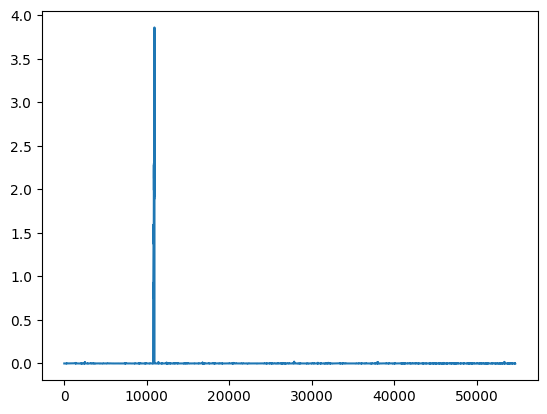

In [17]:
plt.plot(y_test)

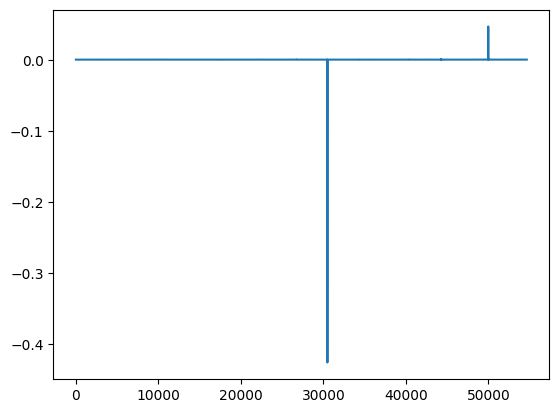

In [18]:
plt.plot(y_pred)

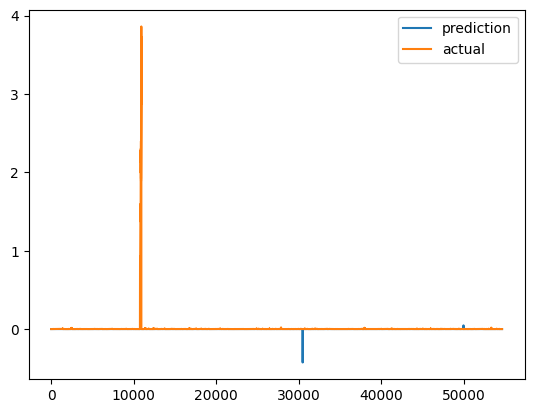

In [15]:
x = np.array(range(0, 54662))
plt.plot(x, y_pred, label='prediction')
plt.plot(x, y_test, label='actual')
plt.legend()
plt.show()